### Loading the super-tensor and creating the temporal networks

To load the super tensor and compute the netowork measures on the data the class __temporal_network__ is used.

In [1]:
import numpy                 as     np
import networkx              as     nx
import matplotlib.pyplot     as     plt
import scipy.signal
import time
from   GDa.temporal_network  import temporal_network
from   tqdm                  import tqdm
from   joblib                import Parallel, delayed
from   scipy                 import stats

In [2]:
def smooth(x, w):
    return scipy.signal.fftconvolve(x, np.ones([1,w])/w, mode='same')

To instantiate the __temporal_network__ we have to supply the monkey name, the session, and date to its constructor.

In [3]:
# Instantiating a temporal network object
net =  temporal_network(monkey='lucy', date=150128, session=1)

When instantiated, the temporal network object will load the recording info for the monkey, date, and sesion specified as well as the super tensor;

The super-tensor has dimensions [Number of pairs, Number of frequency bands, Number of trials * Time]. So far we are using the following bands:

- $\theta$  = [4,8[    Hz;
- $\alpha$  = [8,15[   Hz;
- $\beta$   = [15,30[  Hz;
- $\gamma$  = [30,60[  Hz;

Next, we can plot the supertensor (for better visualization bellow we plot only for ten trials):

In [4]:
net.super_tensor.shape

(1176, 4, 131760)

Text(0.5, 0, 'Time (s)')

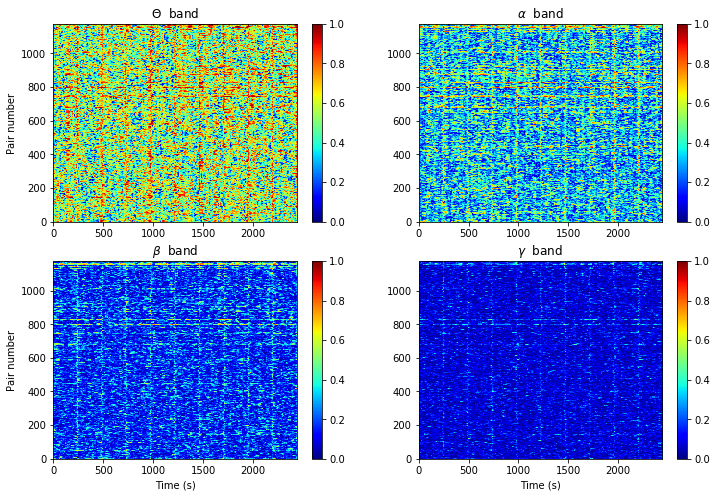

In [5]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(net.super_tensor[:,0,:2440], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\Theta$  band')
plt.ylabel('Pair number')
plt.subplot(2,2,2)
plt.imshow(net.super_tensor[:,1,:2440], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\alpha$  band')
plt.subplot(2,2,3)
plt.imshow(net.super_tensor[:,2,:2440], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\beta$  band')
plt.ylabel('Pair number')
plt.xlabel('Time (s)')
plt.subplot(2,2,4)
plt.imshow(net.super_tensor[:,3,:2440], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\gamma$  band')
plt.xlabel('Time (s)')

The super tensor can be converted to a adjacency tensor by using the method __convert_to_adjacency__:

In [6]:
net.convert_to_adjacency()

The adjacency tensor has dimensions $[nC, nC,bands,Trials*time]$, where $nC$ is the number of channels, and bands the number of frequency bands.

In [7]:
print('Adjacency tensor shape = ' + str( net.A.shape) )

Adjacency tensor shape = (49, 49, 4, 131760)


Let's plot one layer of the adjacency tensor below:

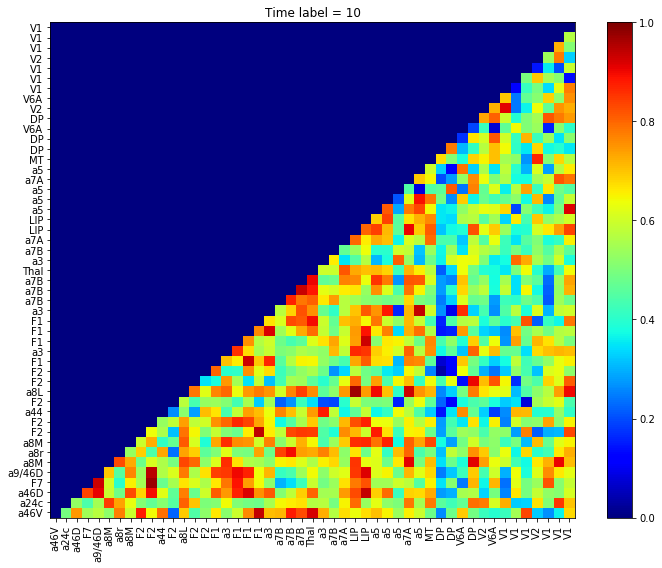

In [8]:
plt.figure(figsize=(10,8))
plt.imshow(net.A[:,:,0,10],aspect='auto',cmap='jet',origin='lower', vmin=0, vmax=1);plt.colorbar()
plt.title('Time label = ' + str(10))
plt.xticks(range(49), net.session_info['areas'], rotation = 90)
plt.yticks(range(49), net.session_info['areas'])
plt.tight_layout()

In [9]:
net.compute_coherence_thresholds(q = .80)

In [10]:
net.coh_thr

{'0': array([0.71988499]),
 '1': array([0.48963165]),
 '2': array([0.26207518]),
 '3': array([0.13517255])}

In [11]:
#net.compute_nodes_degree(0, thr = None)
#net.compute_nodes_degree(1, thr = None)
#net.compute_nodes_degree(2, thr = None)
#net.compute_nodes_degree(3, thr = None)
Parallel(n_jobs=4, backend='threading', timeout=1e6)(
    delayed(net.compute_nodes_degree)(band, thr=None) for band in range(4) )

[None, None, None, None]

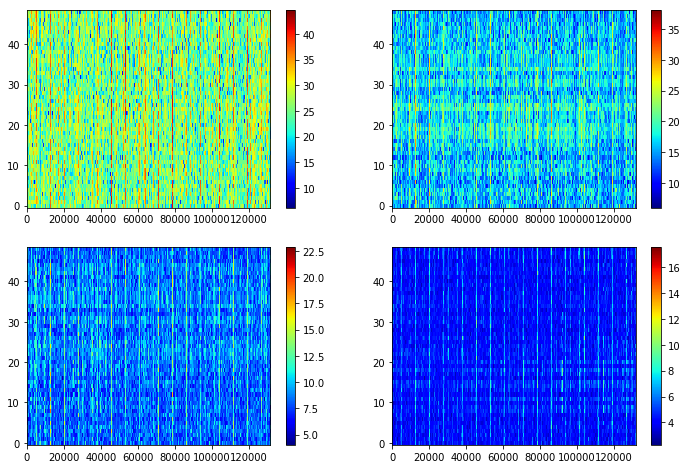

In [13]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(net.node_degree['w']['0'], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(net.node_degree['w']['1'], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(net.node_degree['w']['2'], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(net.node_degree['w']['3'], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

Text(0.5, 1.0, 'Match')

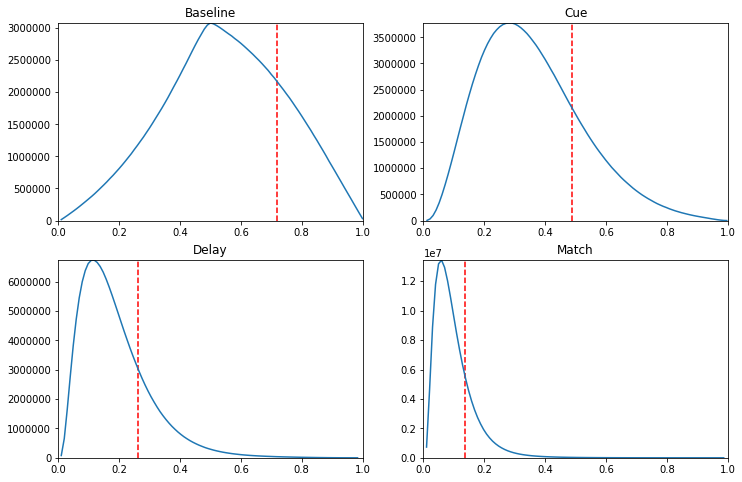

In [14]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
n1, x1 = np.histogram(net.super_tensor[:,0,:].flatten(order='C'), 100)
plt.plot(x1[1:],n1)
plt.ylim([0, n1.max()+0.1])
plt.xlim([0,1])
plt.vlines(net.coh_thr['0'], 0, n1.max()+0.1, linestyle='--', color='r')
plt.title('Baseline')
plt.subplot(2,2,2)
n2, x2 = np.histogram(net.super_tensor[:,1,:].flatten(), 100)
plt.plot(x2[1:],n2)
plt.ylim([0, n2.max()+0.1])
plt.xlim([0,1])
plt.vlines(net.coh_thr['1'], 0, n2.max()+0.1, linestyle='--', color='r')
plt.title('Cue')
plt.subplot(2,2,3)
n3, x3 = np.histogram(net.super_tensor[:,2,:].flatten(), 100)
plt.plot(x3[1:],n3)
plt.ylim([0, n3.max()+0.1])
plt.xlim([0,1])
plt.vlines(net.coh_thr['2'], 0, n3.max()+0.1, linestyle='--', color='r')
plt.title('Delay')
plt.subplot(2,2,4)
n4, x4 = np.histogram(net.super_tensor[:,3,:].flatten(), 100)
plt.plot(x4[1:],n4)
plt.ylim([0, n4.max()+0.1])
plt.xlim([0,1])
plt.vlines(net.coh_thr['3'], 0, n4.max()+0.1, linestyle='--', color='r')
plt.title('Match')

In [15]:
net.create_stages_time_grid()

In [16]:
stages = np.zeros([net.session_info['nT'],len(net.tarray)])
ii     = [net.t_baseline.reshape(net.session_info['nT'],len(net.tarray)), 
          net.t_cue.reshape(net.session_info['nT'],len(net.tarray)), 
          net.t_delay.reshape(net.session_info['nT'],len(net.tarray)),
          net.t_match.reshape(net.session_info['nT'],len(net.tarray))]
for i in range(4):
    stages = stages - i * ii[i]

Text(0.5, 0, 'Time')

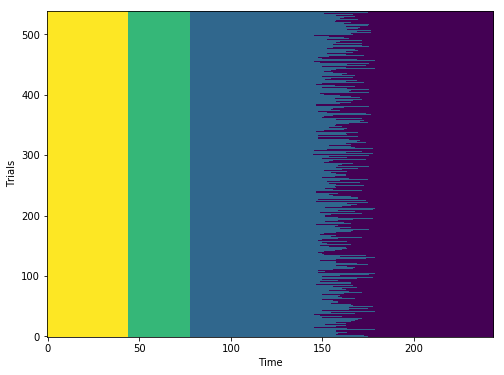

In [17]:
plt.figure(figsize = (8,6))
plt.imshow(stages, aspect='auto',cmap='viridis',origin='lower')
plt.ylabel('Trials')
plt.xlabel('Time')

In [18]:
net.super_tensor.shape

(1176, 4, 131760)

In [20]:
net.node_degree['w']['0'].shape

(49, 131760)

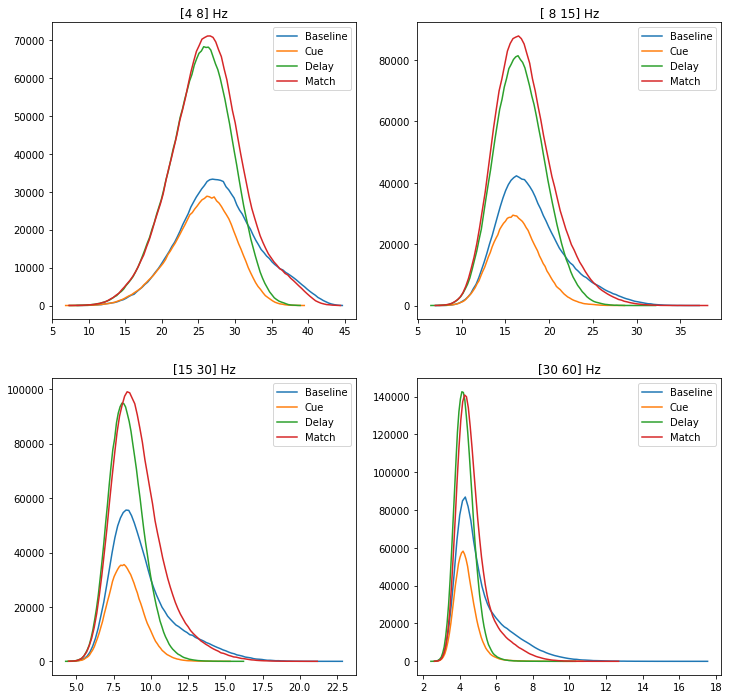

In [21]:
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    n1,x1 = np.histogram(net.node_degree['w'][str(i)][:, net.t_baseline], 100)
    n2,x2 = np.histogram(net.node_degree['w'][str(i)][:, net.t_cue], 100)
    n3,x3 = np.histogram(net.node_degree['w'][str(i)][:, net.t_delay], 100)
    n4,x4 = np.histogram(net.node_degree['w'][str(i)][:, net.t_match], 100)
    plt.plot(x1[2:], n1[1:], label='Baseline')
    plt.plot(x2[2:], n2[1:], label='Cue')
    plt.plot(x3[2:], n3[1:], label='Delay')
    plt.plot(x4[2:], n4[1:], label='Match')
    plt.title(str(net.bands[i]) + ' Hz')
    plt.legend()

In [22]:
#Parallel(n_jobs=4, backend='threading', timeout=1e6)(
#    delayed(net.compute_nodes_clustering)(band, thr=net.coh_thr[str(i)]) for band in range(4) )
net.compute_nodes_clustering(band=0, thr=net.coh_thr['0'])
net.compute_nodes_clustering(band=1, thr=net.coh_thr['1'])
net.compute_nodes_clustering(band=2, thr=net.coh_thr['2'])
net.compute_nodes_clustering(band=3, thr=net.coh_thr['3'])

100%|██████████| 131760/131760 [06:17<00:00, 349.38it/s]


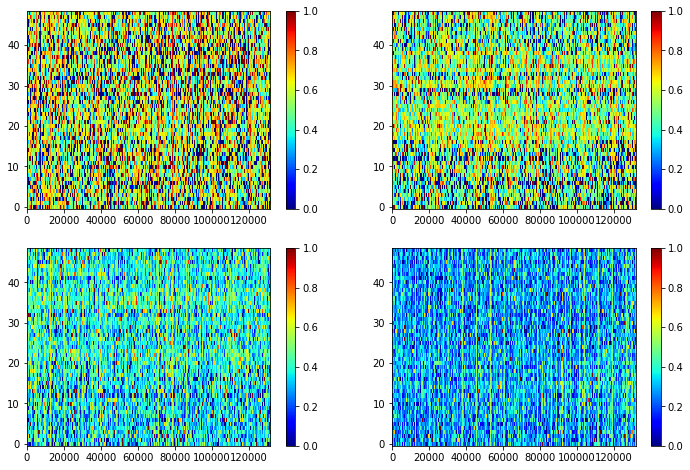

In [24]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(net.clustering['b']['0'], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(net.clustering['b']['1'], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(net.clustering['b']['2'], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(net.clustering['b']['3'], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

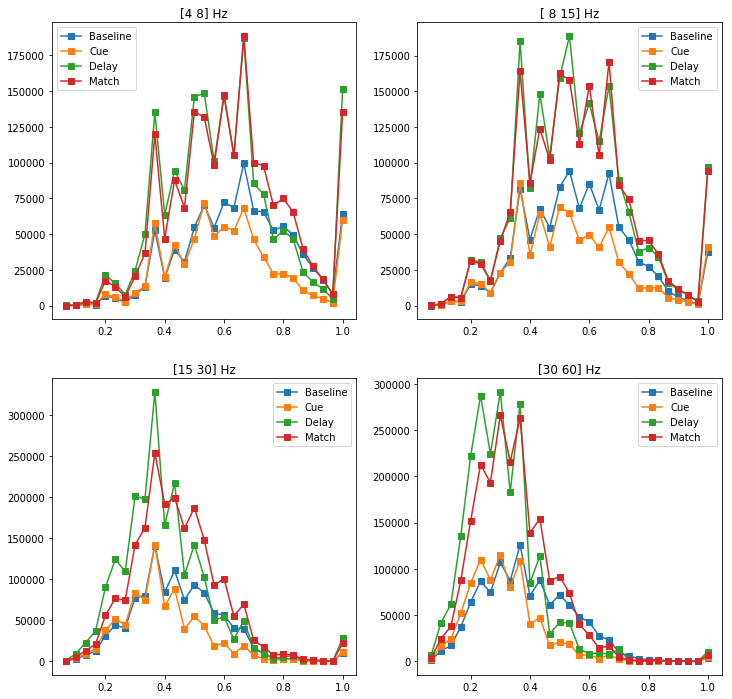

In [26]:
w = 1
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    n1,x1 = np.histogram(smooth(net.clustering['b'][str(i)][:, net.t_baseline], w), 30)
    n2,x2 = np.histogram(smooth(net.clustering['b'][str(i)][:, net.t_cue], w), 30)
    n3,x3 = np.histogram(smooth(net.clustering['b'][str(i)][:, net.t_delay], w), 30)
    n4,x4 = np.histogram(smooth(net.clustering['b'][str(i)][:, net.t_match], w), 30)
    plt.plot(x1[2:], n1[1:], 's-', label='Baseline')
    plt.plot(x2[2:], n2[1:], 's-', label='Cue')
    plt.plot(x3[2:], n3[1:], 's-', label='Delay')
    plt.plot(x4[2:], n4[1:], 's-', label='Match')
    plt.title(str(net.bands[i]) + ' Hz')
    plt.legend()

In [27]:
net.compute_nodes_coreness(band=0, thr=net.coh_thr['0'])
net.compute_nodes_coreness(band=1, thr=net.coh_thr['1'])
net.compute_nodes_coreness(band=2, thr=net.coh_thr['2'])
net.compute_nodes_coreness(band=3, thr=net.coh_thr['3'])

100%|██████████| 131760/131760 [02:18<00:00, 951.10it/s] 


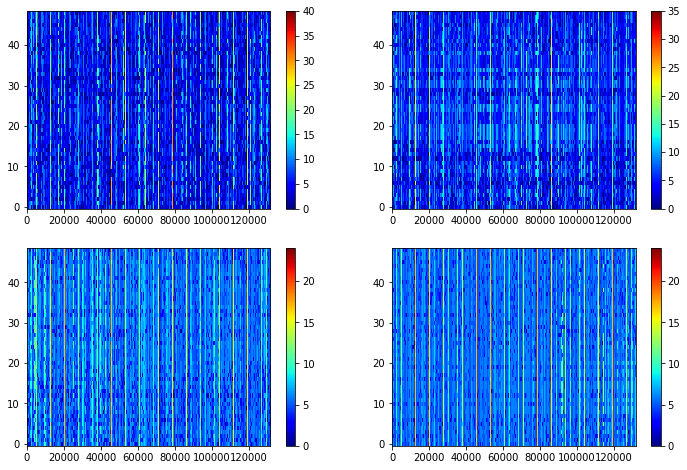

In [28]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(net.coreness['b']['0'], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(net.coreness['b']['1'], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(net.coreness['b']['2'], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(net.coreness['b']['3'], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

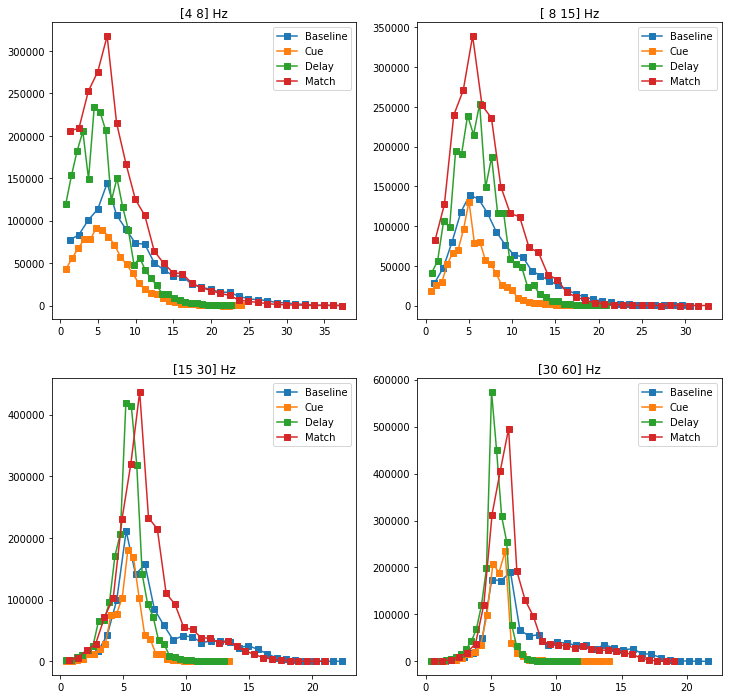

In [29]:
w = 5
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    n1,x1 = np.histogram(smooth( net.coreness['b'][str(i)][:, net.t_baseline], w), 30)
    n2,x2 = np.histogram(smooth( net.coreness['b'][str(i)][:, net.t_cue], w), 30)
    n3,x3 = np.histogram(smooth( net.coreness['b'][str(i)][:, net.t_delay], w), 30)
    n4,x4 = np.histogram(smooth( net.coreness['b'][str(i)][:, net.t_match], w), 30)
    plt.plot(x1[1:], n1[:], 's-', label='Baseline')
    plt.plot(x2[1:], n2[:], 's-', label='Cue')
    plt.plot(x3[1:], n3[:], 's-', label='Delay')
    plt.plot(x4[1:], n4[:], 's-', label='Match')
    plt.title(str(net.bands[i]) + ' Hz')
    plt.legend()

In [79]:
from GDa.graphics.plot_brain_sketch import plot_node_brain_sketch, plot_edge_brain_sketch

In [80]:
#for i in range(244):
#    plt.figure()
#    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), net.A[:,0,i])

In [30]:
# Brain nets
'''
for i in tqdm( range(244) ):
    if net.tarray[i] < 0:
        color = 'r'
        title = 'Baseline'
    if net.tarray[i] >= 0 and net.tarray[i] < (net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'b'
        title = 'Cue'
    if net.tarray[i] >= (net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000 and net.tarray[i] < (net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'm'
        title = 'Delay'
    if net.tarray[i] >= (net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'k'
        title = 'Match'
    w = net.super_tensor[:,0,i]>.7
    plot_edge_brain_sketch(net.session_info['pairs'], net.session_info['channels_labels'].astype(int), w)
    plt.title(title)
    plt.savefig('figures/net_'+str(i)+'.png')
    plt.close()
'''

"\nfor i in tqdm( range(244) ):\n    if net.tarray[i] < 0:\n        color = 'r'\n        title = 'Baseline'\n    if net.tarray[i] >= 0 and net.tarray[i] < (net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000:\n        color = 'b'\n        title = 'Cue'\n    if net.tarray[i] >= (net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000 and net.tarray[i] < (net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000:\n        color = 'm'\n        title = 'Delay'\n    if net.tarray[i] >= (net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000:\n        color = 'k'\n        title = 'Match'\n    w = net.super_tensor[:,0,i]>.7\n    plot_edge_brain_sketch(net.session_info['pairs'], net.session_info['channels_labels'].astype(int), w)\n    plt.title(title)\n    plt.savefig('figures/net_'+str(i)+'.png')\n    plt.close()\n"

In [31]:
# COreness maps
'''
plt.figure(figsize=(12,8))
for i in tqdm( range(net.session_info['nT']) ):
    plt.figure()
    plt.imshow(net.coreness['1']['b'][:,i*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=15, extent=[-0.65,3.00,0,48]); plt.colorbar()
    plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
    plt.yticks(range(49), net.session_info['areas'])
    plt.title('Trial = ' + str(i+1) + ', threshold = 0.7')
    plt.savefig('figures/core_alpha_'+str(i)+'.png')
    plt.close()
'''

"\nplt.figure(figsize=(12,8))\nfor i in tqdm( range(net.session_info['nT']) ):\n    plt.figure()\n    plt.imshow(net.coreness['1']['b'][:,i*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=15, extent=[-0.65,3.00,0,48]); plt.colorbar()\n    plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')\n    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')\n    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')\n    plt.yticks(range(49), net.session_info['areas'])\n    plt.title('Trial = ' + str(i+1) + ', threshold = 0.7')\n    plt.savefig('figures/core_alpha_'+str(i)+'.png')\n    plt.close()\n"

In [32]:
'''
plt.figure(figsize=(12,8))
for i in tqdm( range(net.session_info['nT']) ):
    plt.figure()
    plt.imshow(net.clustering['1']['b'][:,i*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=1, extent=[-0.65,3.00,0,48]); plt.colorbar()
    plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
    plt.yticks(range(49), net.session_info['areas'])
    plt.title('Trial = ' + str(i+1) + ', threshold = ' + str(net.coh_thr['1']))
    plt.savefig('figures/clustering_alpha_'+str(i)+'.png')
    plt.close()
'''

"\nplt.figure(figsize=(12,8))\nfor i in tqdm( range(net.session_info['nT']) ):\n    plt.figure()\n    plt.imshow(net.clustering['1']['b'][:,i*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=1, extent=[-0.65,3.00,0,48]); plt.colorbar()\n    plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')\n    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')\n    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')\n    plt.yticks(range(49), net.session_info['areas'])\n    plt.title('Trial = ' + str(i+1) + ', threshold = ' + str(net.coh_thr['1']))\n    plt.savefig('figures/clustering_alpha_'+str(i)+'.png')\n    plt.close()\n"

Text(0.5, 1.0, 'Trial = 1, threshold = 0.7')

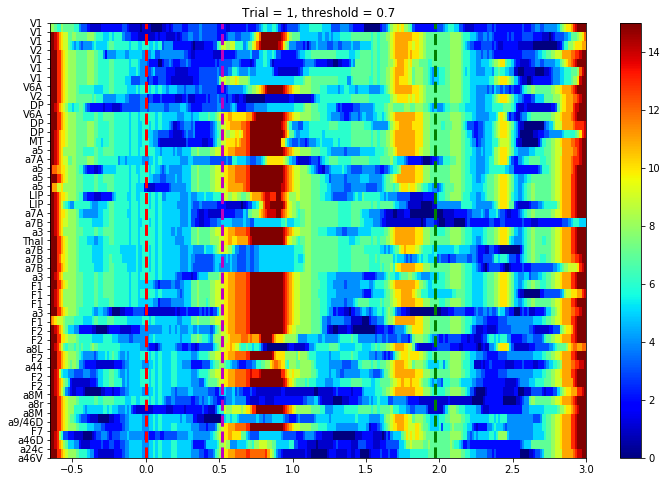

In [34]:
i=0
plt.figure(figsize=(12,8))
plt.imshow(net.coreness['b']['1'][:,(i)*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=15, extent=[-0.65,3.00,0,48]); plt.colorbar()
plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
plt.yticks(range(49), net.session_info['areas'])
plt.title('Trial = ' + str(i+1) + ', threshold = 0.7')

Text(0.5, 1.0, 'Trial = 1, threshold = [0.48963165]')

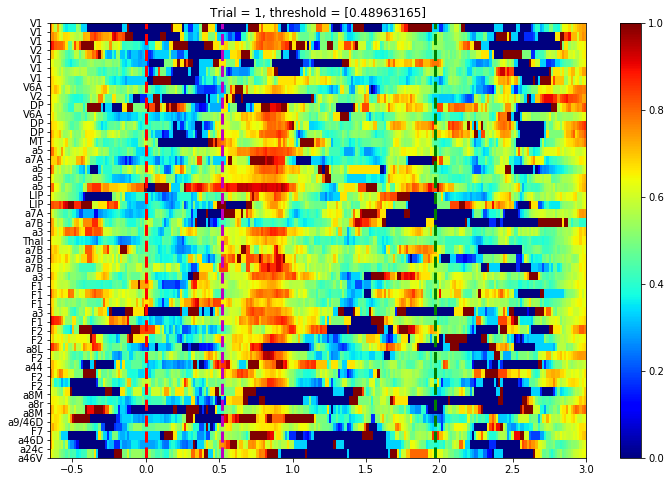

In [35]:
i=0
plt.figure(figsize=(12,8))
plt.imshow(net.clustering['b']['1'][:,(i)*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65,3.00,0,48]); plt.colorbar()
plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
plt.yticks(range(49), net.session_info['areas'])
plt.title('Trial = ' + str(i+1) + ', threshold = ' + str(net.coh_thr['1']))

Text(0.5, 1.0, 'Trial = 1, threshold = 0.7')

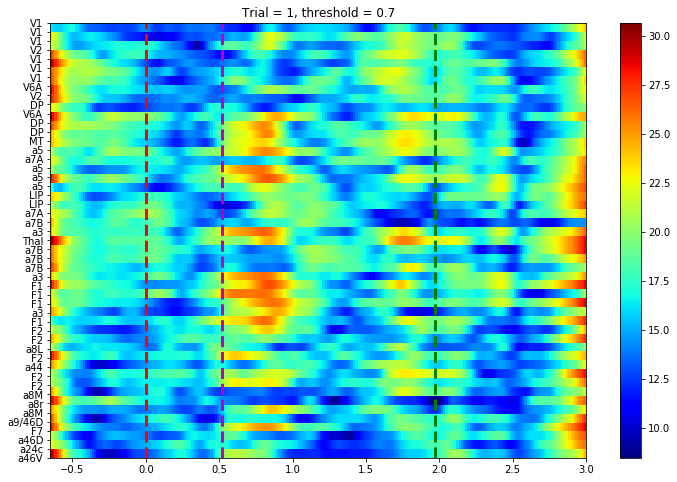

In [36]:
i=0
plt.figure(figsize=(12,8))
plt.imshow(net.node_degree['w']['1'][:,(i)*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65,3.00,0,48]); plt.colorbar()
plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
plt.yticks(range(49), net.session_info['areas'])
plt.title('Trial = ' + str(i+1) + ', threshold = 0.7')

In [19]:
class test:
    
    def __init__(self,): 
        
        self.a = np.zeros(40)
    
    def set_a(self, i):
        self.a[i] = 2*i + 1
        
t = test()

print('Initial value of a = ' + str(t.a) )

Parallel(n_jobs=-40, backend='loky', timeout=1e6)(delayed(t.set_a)(i) for i in range(40) )

print('Final value of a = ' + str(t.a) )

Initial value of a = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Final value of a = [ 1.  3.  5.  7.  9. 11. 13. 15. 17. 19. 21. 23. 25. 27. 29. 31. 33. 35.
 37. 39. 41. 43. 45. 47. 49. 51. 53. 55. 57. 59. 61. 63. 65. 67. 69. 71.
 73. 75. 77. 79.]


In [17]:
net.compute_nodes_clustering_layerwise(band=0, observation=0)

In [18]:
w=net.clustering['0']['w'][:,0]

In [19]:
net.compute_nodes_clustering_layerwise(band=0, observation=0, thr=net.coh_thr['0'])

In [20]:
b=net.clustering['0']['b'][:,0]

131760

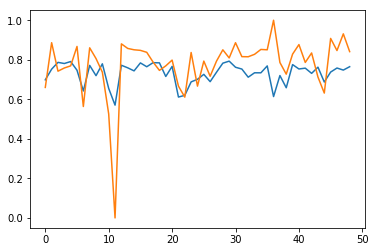

In [22]:
plt.plot(w)
plt.plot(b)
net.A.shape[3]

In [19]:
start = time.time()

Parallel(n_jobs=-1, backend='threading', timeout=1e6)(
    delayed(net.compute_nodes_clustering_layerwise)(0, observation=t, thr=None) for t in range(net.A.shape[3]) )

end = time.time()
print(end - start)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/ohpc/pub/libs/gnu8/python/3.6.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-c428f04efa2a>", line 4, in <module>
    delayed(net.compute_nodes_clustering_layerwise)(0, observation=t, thr=None) for t in range(net.A.shape[3]) )
  File "/home/vinicius/.local/lib/python3.6/site-packages/joblib/parallel.py", line 1061, in __call__
    self.retrieve()
  File "/home/vinicius/.local/lib/python3.6/site-packages/joblib/parallel.py", line 940, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/usr/lib64/python3.6/multiprocessing/pool.py", line 638, in get
    self.wait(timeout)
  File "/usr/lib64/python3.6/multiprocessing/pool.py", line 635, in wait
    self._event.wait(timeout)
  File "/usr/lib64/python3.6/threading.py", line 551, in wait
    signaled = self._cond.wait(timeout)
  File "/usr/lib64/python3.

KeyboardInterrupt: 